# Predicting LOS of patients during their stay in the Intensive Care Unit in the MIMIC-III 
Authors : Cosmin-Nicolae Tianu, Codruta-Elen Jucan, George Tofan  

## Objective
Accurately forecasting the Length of Stay (LOS) of patients in the Intensive Care Unit (ICU) is critical for resource allocation, clinical decision-making, and improving patient outcomes. This document outlines the development and optimization of a machine learning pipeline to predict ICU LOS using the MIMIC-III (Medical Information Mart for Intensive Care) dataset, a rich but challenging clinical database.  

## Challenges
- Skewed LOS distribution: Most patients stay ≤22 days, but a long tail of extended stays complicates modeling.
- Sparse, irregular time-series data: Clinical measurements (e.g., lab values, vitals) are recorded at varying frequencies.
- High-dimensional features: Thousands of potential predictors require careful selection to avoid overfitting  

## Why This Matters
- Clinical utility: Earlier, accurate LOS predictions can aid ICU bed management and discharge planning.
- Methodological insights: Demonstrates how to handle real-world clinical data constraints (missingness, skewness, high dimensionality).

# Disease choice
We aimed to identify a disease that would provide:
- Sufficient sample size: Enough ICU cases for robust statistical analysis
- Clinical relevance: A condition with significant impact on ICU resource utilization
- Temporal predictability: Clear patterns of clinical measurements within the critical first 24 hours of ICU admission

After querying the MIMIC-III database for conditions meeting these criteria, we selected Pneumonia (ICD-9 code 482.83) based on:
- High prevalence in ICU populations
- Well-defined clinical markers for monitoring
- Consistent patterns of clinical deterioration that often require ICU admission

## Loading relational MIMIC-III tables
We extracted and merged data from multiple MIMIC-III relational tables:

- PATIENTS table:
    - Demographic information (age, gender, ethnicity)

- ADMISSIONS table:
    -  Hospital admission/discharge timestamps
    -  Primary and secondary diagnoses

- ICUSTAYS table:

    - ICU admission/discharge timestamps

    - Length of stay calculation

- CHARTEVENTS table (first 24 hours):

    - Vital signs (heart rate, blood pressure, SpO₂)

    - Respiratory parameters (ventilator settings, FiO₂)

    - Neurological assessments (GCS scores)
- DIAGNOSES_ICD table:

    - Confirmation of primary pneumonia diagnosis

- D_ITEMS table:
    - Item description

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

data_path = "./data_sets/"

df_patients= pd.read_csv(data_path + 'PATIENTS.csv.gz')        
df_admissions = pd.read_csv(data_path + 'ADMISSIONS.csv.gz')        
df_icustays = pd.read_csv(data_path + 'ICUSTAYS.csv.gz')     
df_diagnoses = pd.read_csv(data_path + 'DIAGNOSES_ICD.csv.gz', low_memory=False) 


The integration of MIMIC-III's relational tables was carefully engineered to ensure data accuracy, temporal consistency, and clinical validity for our pneumonia cohort.

In [3]:
# Filter for Pneumonia (ICD-9 = 48283)
df_diagnoses = df_diagnoses[df_diagnoses['ICD9_CODE'] == '48283'][['SUBJECT_ID', 'HADM_ID', 'ICD9_CODE']]

df_admissions_merged = pd.merge(
    df_diagnoses,
    df_admissions[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'ETHNICITY']],
    on=['SUBJECT_ID', 'HADM_ID'],
    how='left'
)

print('Number of hospital admissions: ', df_admissions_merged.shape[0])

df_icustays_merged = pd.merge(
    df_admissions_merged,
    df_icustays[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'INTIME', 'LOS']],
    on=['SUBJECT_ID', 'HADM_ID'],
    how='left'
)

print('Number of icu stays: ', df_icustays_merged.shape[0])

df_icustays_patients_merged = pd.merge(
    df_icustays_merged,
    df_patients[['SUBJECT_ID', 'GENDER', 'DOB']],
    on='SUBJECT_ID',
    how='left'
)

df_icustays_patients_merged.head(3)

Number of hospital admissions:  264
Number of icu stays:  307


,SUBJECT_ID,HADM_ID,ICD9_CODE,ADMITTIME,ETHNICITY,ICUSTAY_ID,INTIME,LOS,GENDER,DOB
0,114,178393,48283,2146-08-29 01:18:00,UNKNOWN/NOT SPECIFIED,258626,2146-08-29 17:59:00,1.8132,M,2098-05-09 00:00:00
1,339,112625,48283,2187-04-20 23:10:00,BLACK/AFRICAN AMERICAN,221278,2187-04-20 23:10:50,31.7018,F,2120-07-17 00:00:00
2,285,165312,48283,2152-09-21 22:47:00,HISPANIC OR LATINO,238023,2152-09-21 22:48:50,28.6880,M,2107-05-16 00:00:00


There number icu stays which have chart events is of 140, this being enough to have a decent data frame.

In [4]:
df_chart_events =  pd.read_csv(data_path + 'd_pneumonia.csv', low_memory=False) 

# Merge df_merged with CHARTEVENTS (left join to preserve all ICU stays)
df_merged_with_chartevents = pd.merge(
    df_icustays_patients_merged, 
    df_chart_events[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'ITEMID', 'VALUENUM','CHARTTIME']].drop_duplicates(),
    on=['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID'],
    how='left',
    indicator=True  # Adds a column '_merge' to show match status
)

has_chartevents = df_merged_with_chartevents['_merge'] == 'both'
no_chartevents = df_merged_with_chartevents['_merge'] == 'left_only'

icu_with_data = df_merged_with_chartevents[has_chartevents]['ICUSTAY_ID'].unique()
icu_without_data = df_merged_with_chartevents[no_chartevents]['ICUSTAY_ID'].unique()

print(f"ICU stays WITH CHARTEVENTS data: {len(icu_with_data)}")
print(f"ICU stays WITHOUT CHARTEVENTS data: {len(icu_without_data)}")

print(df_merged_with_chartevents.shape)
 
df_merged_with_chartevents.head(2)

ICU stays WITH CHARTEVENTS data: 145
ICU stays WITHOUT CHARTEVENTS data: 162
(986958, 14)


,SUBJECT_ID,HADM_ID,ICD9_CODE,ADMITTIME,ETHNICITY,ICUSTAY_ID,INTIME,LOS,GENDER,DOB,ITEMID,VALUENUM,CHARTTIME,_merge
0,114,178393,48283,2146-08-29 01:18:00,UNKNOWN/NOT SPECIFIED,258626,2146-08-29 17:59:00,1.8132,M,2098-05-09 00:00:00,211.0,72.0,2146-08-30 10:00:00,both
1,114,178393,48283,2146-08-29 01:18:00,UNKNOWN/NOT SPECIFIED,258626,2146-08-29 17:59:00,1.8132,M,2098-05-09 00:00:00,581.0,102.0,2146-08-30 10:00:00,both


An inner join in the last merge could've saved this step, but now we need to remove the icu stays without chart events.

In [5]:
df_final = df_merged_with_chartevents[df_merged_with_chartevents['_merge'] == 'both'].copy()

# Optional: You can now drop the '_merge' column as it's no longer needed
df_final = df_final.drop(columns=['_merge'])

print(f"Shape of the original DataFrame: {df_merged_with_chartevents.shape}")
print(f"Shape of the final DataFrame (with data): {df_final.shape}")
df_final.head(3)

Shape of the original DataFrame: (986958, 14)
Shape of the final DataFrame (with data): (986796, 13)


,SUBJECT_ID,HADM_ID,ICD9_CODE,ADMITTIME,ETHNICITY,ICUSTAY_ID,INTIME,LOS,GENDER,DOB,ITEMID,VALUENUM,CHARTTIME
0,114,178393,48283,2146-08-29 01:18:00,UNKNOWN/NOT SPECIFIED,258626,2146-08-29 17:59:00,1.8132,M,2098-05-09 00:00:00,211.0,72.0,2146-08-30 10:00:00
1,114,178393,48283,2146-08-29 01:18:00,UNKNOWN/NOT SPECIFIED,258626,2146-08-29 17:59:00,1.8132,M,2098-05-09 00:00:00,581.0,102.0,2146-08-30 10:00:00
2,114,178393,48283,2146-08-29 01:18:00,UNKNOWN/NOT SPECIFIED,258626,2146-08-29 17:59:00,1.8132,M,2098-05-09 00:00:00,618.0,20.0,2146-08-30 10:00:00


All of this steps were also done for bronchitis, but we were left with only 48 icu stays with chart events which is by far insuficient as a dataframe to train and validate a model.

# Statistical analisys and visualization of patients with Pneumonia

## Dataframe cleaning preparation for the analysis 
- Since the time window of 24 hours was chosen for prediction, all chart events past that time will be discarded
- There are 4 very far outliers with LOS above 60 days and they will be discarded since they are not enough to prove helpful for the model training
- Based on the fact that 75% of the admissions have a LOS under 21 days and 87.2% have a LOS under 30 days, entries with more than that will also be discarded
- Not all ICU stays have all the item values present
    - The two possible approaces of dealing with that missing data are imputing 0 in their place or leaving them as null
    - Since XGBoost, the model planned to be trained, works well with missing values, these will be left as null
    - In order to mark their missing as a relevant feature, a count of the number of their appearances will be added for each item, 0 meaning a missing value

We need to take out all the events that happen outside of the first 24h windows of a patient's stay to be able to visualize a patient 24h in the ICU and its relation with items and also the simplify the dataframe.

(92430, 14)


<Axes: xlabel='ITM_ADM_TIME', ylabel='Count'>

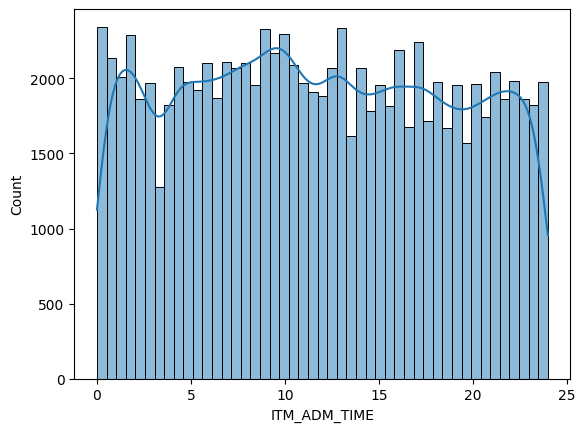

In [6]:
import seaborn as sns

df_final['INTIME'] = pd.to_datetime(df_final['INTIME'])
df_final['CHARTTIME'] = pd.to_datetime(df_final['CHARTTIME'])

df_final['ITM_ADM_TIME'] = (df_final['CHARTTIME'] - df_final['INTIME']).dt.total_seconds() / 3600
df_final = df_final[(df_final['ITM_ADM_TIME'] <= 24) & (df_final['ITM_ADM_TIME'] >= 0)]

print(df_final.shape)

sns.histplot(df_final['ITM_ADM_TIME'], kde=True)

We normalize it to a time interval of (0, 1) to make any possible model easier to be trained and to be able to interpret results.

<Axes: xlabel='ITM_ADM_TIME', ylabel='Count'>

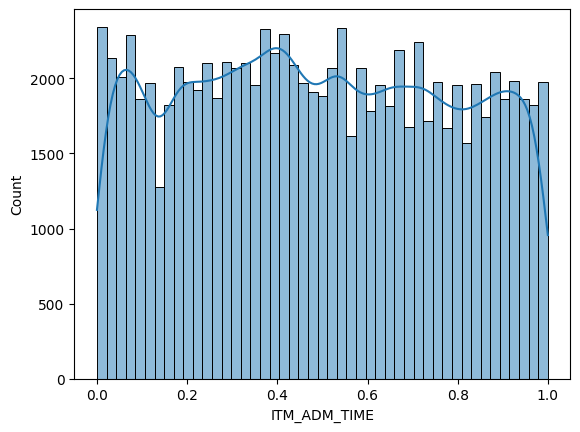

In [7]:
df_final['ITM_ADM_TIME'] = df_final['ITM_ADM_TIME'] / 24.0

sns.histplot(df_final['ITM_ADM_TIME'], kde=True)

## Patients overview
Three patients were chosen with little, medium and high LOS in order to visualize different trends.

A sorted CSV of the ICU stays has been generated using an sql query which is saved to the csv `norm_pneumonia.csv` to be able to chose said three examples.

In [8]:
from statsmodels.nonparametric.smoothers_lowess import lowess

df = pd.read_csv("./data_sets/norm_pneumonia.csv")

df['ITM_ADM_TIME'] = df['NORMTIME']
df.drop(columns='NORMTIME')

# Define plotting function
def plot_icu_data(icu_id):
    filtered = df[df["ICUSTAY_ID"] == icu_id]
    value_min = 0
    value_max = 200
    filtered_limited = filtered[
        (filtered["VALUENUM"] >= value_min) & (filtered["VALUENUM"] <= value_max)
    ]

    # Prepare LOWESS smoothed values
    x = filtered_limited["ITM_ADM_TIME"]
    y = filtered_limited["VALUENUM"]
    lowess_smoothed = lowess(y, x, frac=0.3, return_sorted=True)
    lowess_x = lowess_smoothed[:, 0]
    lowess_y = lowess_smoothed[:, 1]

    # Bootstrap for confidence interval
    bootstraps = []
    for _ in range(100):
        sample = filtered_limited.sample(frac=1, replace=True)
        smoothed = lowess(sample["VALUENUM"], sample["ITM_ADM_TIME"], frac=0.3, return_sorted=True)
        bootstraps.append(np.interp(lowess_x, smoothed[:, 0], smoothed[:, 1]))
    bootstraps = np.array(bootstraps)
    ci_lower = np.percentile(bootstraps, 2.5, axis=0)
    ci_upper = np.percentile(bootstraps, 97.5, axis=0)

    # Plot
    plt.figure(figsize=(10, 7))
    sns.set(style="whitegrid")

    sns.scatterplot(
        data=filtered_limited,
        x="ITM_ADM_TIME",
        y="VALUENUM",
        hue="ITEMID",
        palette="Blues",
        alpha=0.8
    )

    # Add LOWESS trend line
    plt.plot(lowess_x, lowess_y, color="blue", label="Trend")

    # Add ribbon (confidence interval)
    plt.fill_between(lowess_x, ci_lower, ci_upper, color="blue", alpha=0.2, label="95% CI")

    # Adjust legend
    plt.legend(title="ITEMID", loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f"ICU_{icu_id}", fontsize=16)
    plt.xlabel("Time")
    plt.ylabel("Values")
    plt.tight_layout()
    plt.show()


### Small LOS

In this example we can see a slight increase of LOESS over time, but the trend is unstable do to sparse data and high variability.  
Dense concentration of measurements in early stages suggest early implication of doctors that might suggest the shorter LOS.


/home/cox/.local/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


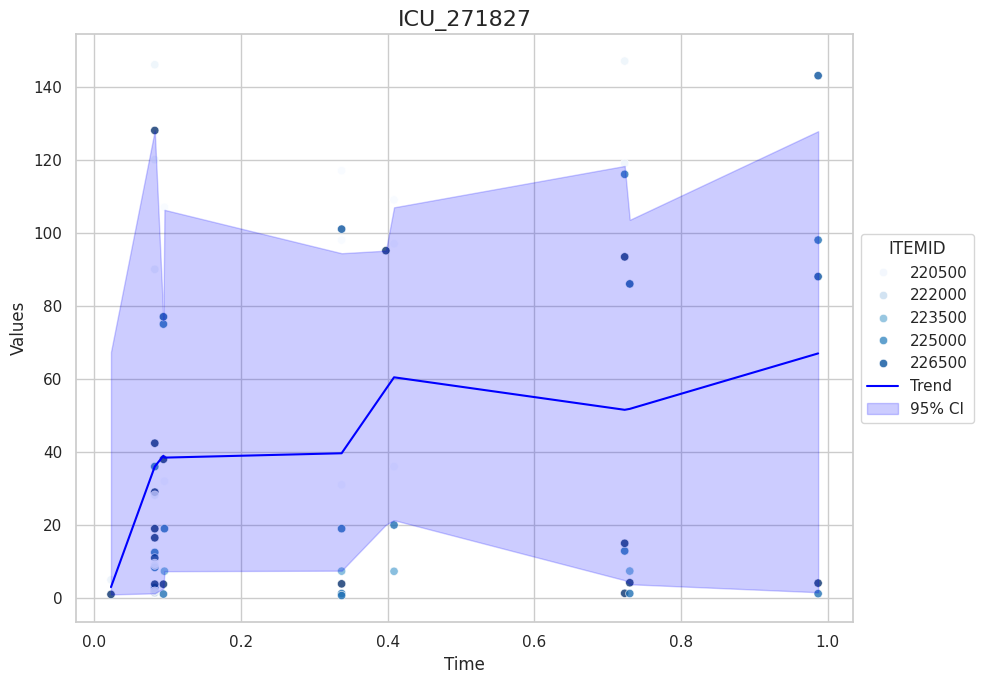

In [9]:
import numpy as np

plot_icu_data(icu_id=271827)

### Medium LOS
Here, LOESS trend display a well formed curve and a consistent trajectory. Also, the evenly spread of items over the ICU stay suggest a stable and systematic mmonitoring over this time period.

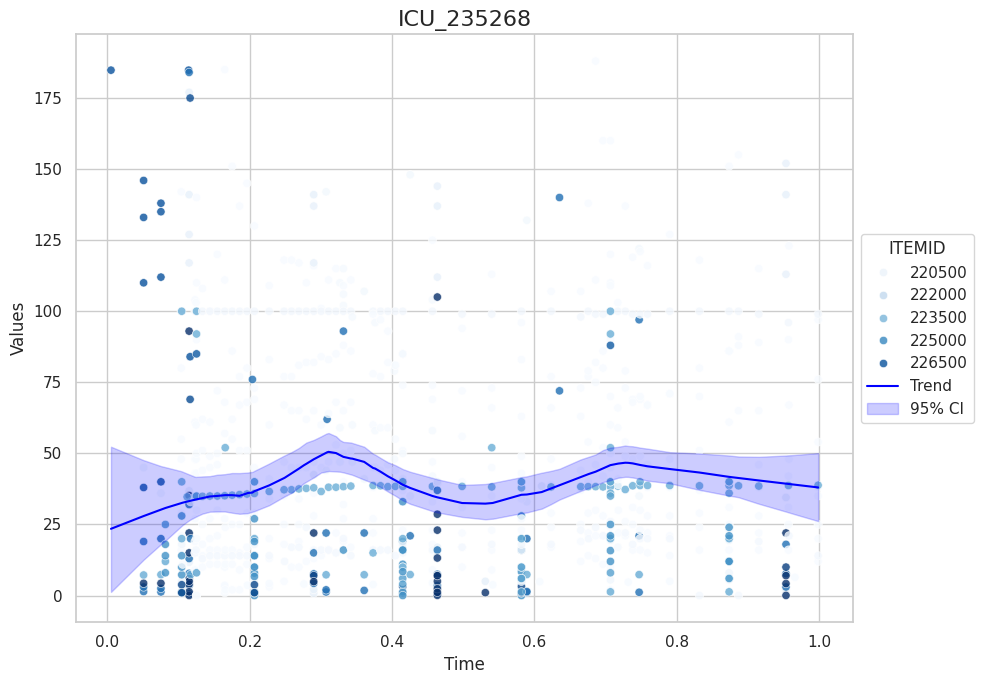

In [10]:
plot_icu_data(icu_id=235268)

### High LOS
This example ilustrates a slight downward slope, possibly due to treatment effects and the spike at 0.9 suggests a check-up.

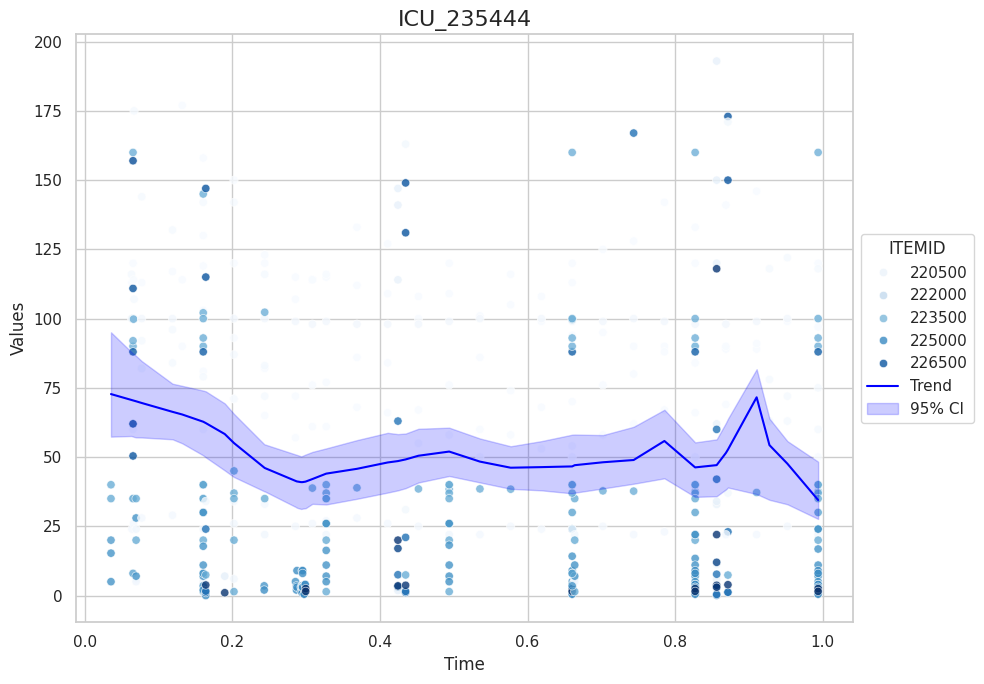

In [11]:
plot_icu_data(icu_id=235444)

# Training and validation of a model to predict LOS
First of all our dataframe needs some processing for the model to be able to digest the data accordingly.

## Data transformation
- The age of the patients is computed from the ICU admission time minus their birth date
    - Patients with ages greater than 89 years old are entered in the database to 300 in order to protect confidentiality
    - All the patients in this case will have their age moved to 91.4, the average of their group
- Categorical features of patients are encoded
    - Gender is label encoded, while ethnicity is encoded using one hot encoding for better model interpretation
- The distribution of the target variable, LOS, is right-skewed
    - In order to have that data better interpretable by a wider range of models, a *log transformation* will be applied on it
### Processing of DOB, INTIME and ADMITTIME
To be able to make use of the dates, we transform them to pandas datetime format and create meaningful features out of them. These are the age, which is the difference between the time of admission in the ICU minus the date of birth, and the  hospital time, which is the time of admission in the ICU minus the hospital admission time.

In [12]:
df_final['DOB'] = pd.to_datetime(df_final['DOB'])
df_final['INTIME'] = pd.to_datetime(df_final['INTIME'])
df_final['ADMITTIME'] = pd.to_datetime(df_final['ADMITTIME'])

df_final['AGE'] = (
    (df_final['INTIME'].dt.year - df_final['DOB'].dt.year) + 
    (df_final['INTIME'].dt.dayofyear - df_final['DOB'].dt.dayofyear) / 365.25
)
df_final['HOSP_TIME'] = (
    (df_final['INTIME'].dt.year - df_final['ADMITTIME'].dt.year) + 
    (df_final['INTIME'].dt.dayofyear - df_final['ADMITTIME'].dt.dayofyear) / 365.25
)
# Can drop DOB, INTIME and ADMITE TIME
# df_merged.drop(columns=['DOB', 'ADMITTIME'], inplace=True)

In this dataset, patients older than 89 years old have been mapped to 300 years old out of privacy reasons. We need their actual age so it has meaning for the future model. This is done by assigning the average of this age group, 91.4, to all of them.

In [13]:
df_final.loc[df_final['AGE'] > 89, 'AGE'] = 91.4 

To make predictions on the LOS on patients at the 24 hour mark of their stay in ICU, the patients that stayed **more** than that, are not useful and will be discarded.

In [14]:
df_final = df_final[df_final['LOS'] > 1]
df_final.head(3)


,SUBJECT_ID,HADM_ID,ICD9_CODE,ADMITTIME,ETHNICITY,ICUSTAY_ID,INTIME,LOS,GENDER,DOB,ITEMID,VALUENUM,CHARTTIME,ITM_ADM_TIME,AGE,HOSP_TIME
0,114,178393,48283,2146-08-29 01:18:00,UNKNOWN/NOT SPECIFIED,258626,2146-08-29 17:59:00,1.8132,M,2098-05-09,211.0,72.0,2146-08-30 10:00:00,0.667361,48.306639,0.0
1,114,178393,48283,2146-08-29 01:18:00,UNKNOWN/NOT SPECIFIED,258626,2146-08-29 17:59:00,1.8132,M,2098-05-09,581.0,102.0,2146-08-30 10:00:00,0.667361,48.306639,0.0
2,114,178393,48283,2146-08-29 01:18:00,UNKNOWN/NOT SPECIFIED,258626,2146-08-29 17:59:00,1.8132,M,2098-05-09,618.0,20.0,2146-08-30 10:00:00,0.667361,48.306639,0.0


### Ethnicity and gender processing
Categorical features of patients are to be encoded.

Within this disease's sub data set there are different ethnicities, those that have less than 5 representatives will be grouped together in an OTHER ethnicity.  

In [15]:

unique_ethnicities = df_final['ETHNICITY'].unique()
print(unique_ethnicities)

ethnicity_counts = df_final['ETHNICITY'].value_counts()
print(ethnicity_counts)

rare_ethnicities = ['HISPANIC/LATINO - PUERTO RICAN', 'WHITE - RUSSIAN', 
                    'HISPANIC/LATINO - DOMINICAN', 'ASIAN - CHINESE',
                    'UNABLE TO OBTAIN', 'PATIENT DECLINED TO ANSWER']

df_final['ETHNICITY'] = df_final['ETHNICITY'].replace(rare_ethnicities, 'OTHER')

ethnicity_counts = df_final['ETHNICITY'].value_counts()
print(ethnicity_counts)

['UNKNOWN/NOT SPECIFIED' 'BLACK/AFRICAN AMERICAN' 'HISPANIC OR LATINO'
 'ASIAN' 'WHITE' 'OTHER' 'WHITE - RUSSIAN'
 'HISPANIC/LATINO - PUERTO RICAN' 'ASIAN - CHINESE' 'UNABLE TO OBTAIN'
 'PATIENT DECLINED TO ANSWER']
ETHNICITY
WHITE                             77730
BLACK/AFRICAN AMERICAN             5450
UNKNOWN/NOT SPECIFIED              2309
HISPANIC OR LATINO                 1810
ASIAN                              1268
OTHER                               883
WHITE - RUSSIAN                     813
UNABLE TO OBTAIN                    753
PATIENT DECLINED TO ANSWER          400
ASIAN - CHINESE                     376
HISPANIC/LATINO - PUERTO RICAN      215
Name: count, dtype: int64
ETHNICITY
WHITE                     77730
BLACK/AFRICAN AMERICAN     5450
OTHER                      3440
UNKNOWN/NOT SPECIFIED      2309
HISPANIC OR LATINO         1810
ASIAN                      1268
Name: count, dtype: int64


The gender is encoded using a Label Encoder since in this data set it has 2 values.

But in the case of ethnicities, using a Label Encoder to encode these values would create an ordinal relationship between them, which will make them lose their meaning. Instead, the etnicities are one hot encoded, with the first column being dropped to prevent multicollinearity.

In [16]:
from sklearn.preprocessing import LabelEncoder

gender_encoder = LabelEncoder()

df_final['GENDER'] = gender_encoder.fit_transform(df_final['GENDER'])

print("Gender Classes:", gender_encoder.classes_)

df_final = pd.get_dummies(
    df_final, 
    columns=['ETHNICITY'], 
    prefix='ETH',
    drop_first=True
    )


df_final.head(3)

Gender Classes: ['F' 'M']


,SUBJECT_ID,HADM_ID,ICD9_CODE,ADMITTIME,ICUSTAY_ID,INTIME,LOS,GENDER,DOB,ITEMID,VALUENUM,CHARTTIME,ITM_ADM_TIME,AGE,HOSP_TIME,ETH_BLACK/AFRICAN AMERICAN,ETH_HISPANIC OR LATINO,ETH_OTHER,ETH_UNKNOWN/NOT SPECIFIED,ETH_WHITE
0,114,178393,48283,2146-08-29 01:18:00,258626,2146-08-29 17:59:00,1.8132,1,2098-05-09,211.0,72.0,2146-08-30 10:00:00,0.667361,48.306639,0.0,False,False,False,True,False
1,114,178393,48283,2146-08-29 01:18:00,258626,2146-08-29 17:59:00,1.8132,1,2098-05-09,581.0,102.0,2146-08-30 10:00:00,0.667361,48.306639,0.0,False,False,False,True,False
2,114,178393,48283,2146-08-29 01:18:00,258626,2146-08-29 17:59:00,1.8132,1,2098-05-09,618.0,20.0,2146-08-30 10:00:00,0.667361,48.306639,0.0,False,False,False,True,False


In [52]:
df_icustays_patients_merged.describe().T

,count,mean,min,25%,50%,75%,max,std
SUBJECT_ID,307.0,33228.550489,114.0,11215.0,25474.0,49267.5,99715.0,28758.748753
HADM_ID,307.0,150245.521173,100395.0,125328.0,152895.0,174117.5,199845.0,27775.541971
ICUSTAY_ID,307.0,252298.661238,200387.0,230449.5,253214.0,275776.0,299728.0,28329.125649
INTIME,307,2150-10-01 05:11:23.130293248,2100-12-10 12:50:48,2125-01-24 21:55:23.500000256,2150-04-22 17:40:51.000000512,2174-08-08 07:02:47.000000512,2207-12-13 20:57:20,NaN
LOS,307.0,15.420087,0.0705,4.42235,11.9535,21.613,84.0409,13.732065
DOB,307,2080-01-13 13:12:42.214983680,1805-12-07 00:00:00,2056-08-04 00:00:00,2088-08-09 00:00:00,2110-02-18 00:00:00,2173-02-23 00:00:00,NaN
AGE,307.0,65.235295,19.350445,57.278234,67.956194,76.819302,91.4,15.791862



- Based on the fact that 75% of the admissions have a LOS under 21 days and 87.2% have a LOS under 30 days, entries with more than that will also be discarded
- Not all ICU stays have all the item values present
    - The two possible approaces of dealing with that missing data are imputing 0 in their place or leaving them as null
    - Since XGBoost, the model planned to be trained, works well with missing values, these will be left as null
    - In order to mark their missing as a relevant feature, a count of the number of their appearances will be added for each item, 0 meaning a missing value

In [17]:
print('Initial size: ', df_final.shape[0])
df_final = df_final[df_final['LOS'] <= 30]
print('Current size: ', df_final.shape[0])


Initial size:  92007
Current size:  87861


Without removal of the outliers, the LOS distribution was right skewed, which would've suggested using the log of the LOS. But after the elimination, log becomes left skewed.

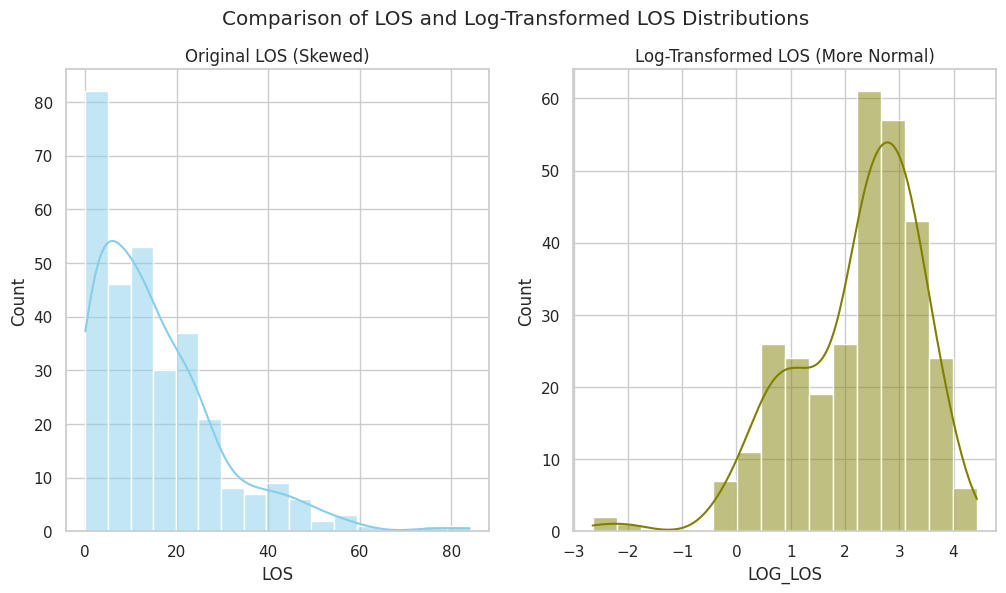

In [18]:
import matplotlib.pyplot as plt

df_final_log = df_icustays_patients_merged.copy()


df_final_log['LOG_LOS'] = np.log(df_final_log['LOS'])

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Comparison of LOS and Log-Transformed LOS Distributions')

sns.histplot(df_final_log['LOS'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Original LOS (Skewed)')

sns.histplot(df_final_log['LOG_LOS'], kde=True, ax=axes[1], color='olive')
axes[1].set_title('Log-Transformed LOS (More Normal)')

# plt.tight_layout()
plt.show()

Age distribution looks good.

<Axes: xlabel='AGE', ylabel='Count'>

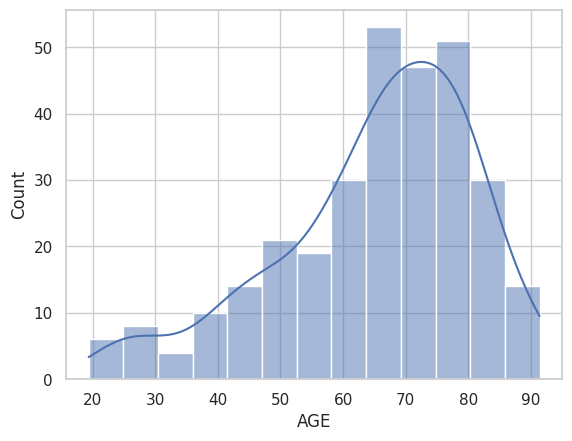

In [19]:
df_icustays_patients_merged['DOB'] = pd.to_datetime(df_icustays_patients_merged['DOB'])
df_icustays_patients_merged['INTIME'] = pd.to_datetime(df_icustays_patients_merged['INTIME'])

df_icustays_patients_merged['AGE'] = (
    (df_icustays_patients_merged['INTIME'].dt.year - df_icustays_patients_merged['DOB'].dt.year) + 
    (df_icustays_patients_merged['INTIME'].dt.dayofyear - df_icustays_patients_merged['DOB'].dt.dayofyear) / 365.25
)

df_icustays_patients_merged.loc[df_icustays_patients_merged['AGE'] > 89, 'AGE'] = 91.4  # Handle MIMIC-III's >89 group

sns.histplot(df_icustays_patients_merged['AGE'], kde=True)

## Feature Engineering
- The time-stamps of each chart event will be normalized as starting from the addmission time
- Given the time-stamped nature of the item entries, the item values for each ICU stay will be aggregated into the following 5 features per item:
    - average
    - standard deviation
    - trend
    - range
    - count
- Since not all ICU stays have the same items in their respective events, only the items with more than 78% appearance will be selected as features
    - This criteria means selecting the first 32 items, multiplied by the number of 5 metrics for each, giving 160 features
    - This sorting is performed by an SQL query, that saves the results into `items_appearance_pneumonia.csv`
### Items aggregation 
We need to introduce the items into our dataframe, we do that by calculating a set of aggregate features for the top 32 most frequent items in our disease.

In [20]:
static_features = df_final.drop_duplicates(subset=['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID'])[
    ['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID','HOSP_TIME', 'AGE', 'GENDER', 
     'ETH_BLACK/AFRICAN AMERICAN', 'ETH_HISPANIC OR LATINO', 
     'ETH_OTHER', 'ETH_UNKNOWN/NOT SPECIFIED', 'ETH_WHITE','LOS']
]

static_features.head()

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,HOSP_TIME,AGE,GENDER,ETH_BLACK/AFRICAN AMERICAN,ETH_HISPANIC OR LATINO,ETH_OTHER,ETH_UNKNOWN/NOT SPECIFIED,ETH_WHITE,LOS
0,114,178393,258626,0.000000,48.306639,1,False,False,False,True,False,1.8132
13145,285,165312,238023,0.000000,45.353183,1,False,True,False,False,False,28.6880
21486,605,115545,248569,0.000000,91.400000,0,False,False,False,False,False,16.8598
46380,3482,192399,202786,0.002738,55.577687,1,False,False,False,False,True,4.9694
48072,2090,138877,256557,0.000000,76.605065,1,False,False,False,False,True,10.0869


In [21]:
import pandas as pd
import numpy as np

# The 'features_df' (for mapping names) is now a separate, optional argument.
def create_feature_matrix(df_events, df_static, item_ids, features_df=None, agg_list=None):
    """
    Creates a feature matrix by combining static data with aggregated time-series features.
    This version correctly accepts a list of ITEMIDs and robustly flattens MultiIndex columns.

    Args:
        df_events (pd.DataFrame): Time-series data with 'SUBJECT_ID', 'ITEMID', 'VALUENUM', 'CHARTTIME'.
        df_static (pd.DataFrame): Static patient data with 'SUBJECT_ID'.
        item_ids (list): A Python list of ITEMIDs to use for feature generation.
        features_df (pd.DataFrame, optional): For mapping ITEMID to readable names. 
                                               Must have 'ITEMID' and 'item_name' columns. Defaults to None.
        agg_list (list, optional): Aggregations to compute. Defaults to ['mean', 'std', 'count', 'range', 'trend'].

    Returns:
        pd.DataFrame: Combined static + aggregated features, with NaN filled as 0.
    """
    if agg_list is None:
        agg_list = ['mean', 'std', 'count', 'range', 'trend']

    # 1. Filter relevant ITEMIDs from the provided list
    df_filtered = df_events[df_events['ITEMID'].isin(item_ids)].copy()
    df_filtered['CHARTTIME'] = pd.to_datetime(df_filtered['CHARTTIME'])

    # 2. Define aggregation calculations 
    def calculate_aggregated_features(group):
        vals = group['VALUENUM']
        count = vals.count()
        features = {}
        for agg in agg_list:
            features[agg] = 0
        if count == 0:
            return pd.Series(features)
        if 'count' in agg_list: features['count'] = count
        if 'mean' in agg_list: features['mean'] = vals.mean()
        if 'std' in agg_list: features['std'] = vals.std() if count > 1 else 0
        if 'range' in agg_list: features['range'] = vals.max() - vals.min() if count > 1 else 0
        if 'trend' in agg_list and count > 1:
            group = group.sort_values('CHARTTIME')
            time_in_hours = (group['CHARTTIME'] - group['CHARTTIME'].iloc[0]).dt.total_seconds() / 3600.0
            valid_indices = time_in_hours.notna() & vals.notna()
            if valid_indices.sum() > 1:
                slope = np.polyfit(time_in_hours[valid_indices], vals[valid_indices], 1)[0]
                features['trend'] = slope if np.isfinite(slope) else 0
        return pd.Series(features)

    # 3. Compute aggregations
    item_stats = (
        df_filtered.groupby(['SUBJECT_ID', 'ITEMID'])
        .apply(calculate_aggregated_features)
        .unstack(fill_value=0)
    )
    
    # 4. Flatten MultiIndex columns 
    if isinstance(item_stats.columns, pd.MultiIndex):
        if features_df is not None:
            # Ensure data types match for mapping
            features_df['ITEMID'] = features_df['ITEMID'].astype(int)
            itemid_to_label = dict(zip(features_df['ITEMID'], features_df['item_name']))
            item_stats.columns = [
                f"{agg}_{itemid_to_label.get(int(itemid), f'ITEM_{itemid}')}"
                for agg, itemid in item_stats.columns
            ]
        else: # If no features_df is provided, use default names
            item_stats.columns = [
                f"{agg}_ITEM_{itemid}" for agg, itemid in item_stats.columns
            ]

    item_stats = item_stats.reset_index()

    # 5. Merge with static data
    model_data = pd.merge(
        df_static,
        item_stats,
        on='SUBJECT_ID',
        how='left'
    ).fillna(0)

    return model_data

The top features have been achieved by quering the dataset and exporting it to `items_appearance_pneumonia` .

In [22]:
top_features_df = pd.read_csv(data_path + 'items_appearance_pneumonia.csv')

top_features_df.head()

,rank,ITEMID,item_name,VALUEUOM,stay_count
0,1,220645.0,Sodium (serum),mEq/L,135
1,2,220615.0,Creatinine,mg/dL,135
2,3,220602.0,Chloride (serum),mEq/L,135
3,4,225624.0,BUN,mg/dL,135
4,5,227443.0,HCO3 (serum),mEq/L,135


In [23]:
top32_features = top_features_df[top_features_df['rank'] <= 32]['ITEMID'].to_list()

print('The number of items is: ', len(top32_features))

The number of items is:  32


For each of these items the mean, standard deviation, count, trend and range are calculated and inserted as features in the dataframe.

In [24]:
model_data_full = create_feature_matrix(
    df_final,
    static_features,
    top32_features, # The list of ITEMIDs
    features_df=top_features_df # The dataframe for naming 
)
print(model_data_full.shape)
model_data_full.head(1)


(126, 172)


/tmp/ipykernel_1368/3013210344.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(calculate_aggregated_features)


,SUBJECT_ID,HADM_ID,ICUSTAY_ID,HOSP_TIME,AGE,GENDER,ETH_BLACK/AFRICAN AMERICAN,ETH_HISPANIC OR LATINO,ETH_OTHER,ETH_UNKNOWN/NOT SPECIFIED,...,trend_Calcium non-ionized,trend_Phosphorous,trend_TCO2 (calc) Arterial,trend_SpO2 Desat Limit,trend_Anion gap,trend_Potassium (serum),trend_HCO3 (serum),trend_Platelet Count,trend_Prothrombin time,trend_INR
0,114,178393,258626,0.0,48.306639,1,False,False,False,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Also, for a better prediction we add the SOFA score, which is widely used in real life.

In [25]:
# Define SOFA-related ITEMIDs 
sofa_itemids = {
    'RESPIRATION': [220224, 223835],  # PaO₂, FiO₂
    'COAGULATION': [828],           # Platelets
    'LIVER': [225690],                 # Bilirubin
    'CARDIOVASCULAR': [220052],       # MAP
    'CNS': [198],                     # GCS
    'RENAL': [220615]           # Creatinine
}

# 1. Flatten the list of ITEMIDs 
all_sofa_ids = [item for sublist in sofa_itemids.values() for item in sublist]

# 2. Apply the filter directly 
df_sofa_components = df_chart_events[df_chart_events['ITEMID'].isin(all_sofa_ids)]

print(f"Found {len(df_sofa_components)} SOFA-related measurements.")
df_sofa_components.head(1)

Found 67420 SOFA-related measurements.


,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED
0,170754,1709,127294,207018,220052,2118-01-04 12:15:00,2118-01-04 14:22:00,19783.0,124.0,124.0,mmHg,0.0,0.0,NaN,NaN


In [26]:
# Extract PaO₂ and FiO₂ (assuming FiO₂ is in %, e.g., 50% = 0.5)
df_pao2 = df_sofa_components[df_sofa_components['ITEMID'] == 220224]
df_fio2 = df_sofa_components[df_sofa_components['ITEMID'] == 223835]
df_pao2

# Merge and calculate PaO₂/FiO₂ ratio
df_respiration = pd.merge(
    df_pao2[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'CHARTTIME', 'VALUENUM']],
    df_fio2[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'CHARTTIME', 'VALUENUM']],
    on=['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'CHARTTIME'],
    suffixes=('_PAO2', '_FIO2')
)

df_respiration['PAO2_FIO2_RATIO'] = df_respiration['VALUENUM_PAO2'] / (df_respiration['VALUENUM_FIO2'] / 100)

# Assign SOFA Respiration Subscore (0-4)
df_respiration['SOFA_RESPIRATION'] = pd.cut(
    df_respiration['PAO2_FIO2_RATIO'],
    bins=[0, 100, 200, 300, 400, float('inf')],
    labels=[4, 3, 2, 1, 0],
    right=False
)

df_respiration.head(2)


,SUBJECT_ID,HADM_ID,ICUSTAY_ID,CHARTTIME,VALUENUM_PAO2,VALUENUM_FIO2,PAO2_FIO2_RATIO,SOFA_RESPIRATION
0,3482,192399,202786,2152-11-18 20:00:00,106.0,30.0,353.333333,1
1,12110,105928,212945,2172-03-02 09:00:00,154.0,50.0,308.000000,1


In [27]:
df_platelets = df_sofa_components[df_sofa_components['ITEMID'] == 828].copy()

df_platelets['SOFA_COAGULATION'] = pd.cut(
    df_platelets['VALUENUM'],
    bins=[0, 20, 50, 100, 150, float('inf')],
    labels=[4, 3, 2, 1, 0],
    right=False
)
df_platelets.head(3)


,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED,SOFA_COAGULATION
941838,35644178,285,165312,238023,828,2152-09-26 01:03:00,2152-09-26 02:08:00,15331.0,181.0,181.0,NaN,NaN,NaN,Final,NotStopd,0
942333,35661979,285,165312,238023,828,2152-10-12 01:42:00,2152-10-12 02:39:00,15331.0,260.0,260.0,NaN,NaN,NaN,Final,NotStopd,0
942532,35667689,285,165312,238023,828,2152-10-18 02:29:00,2152-10-18 03:48:00,15331.0,333.0,333.0,NaN,NaN,NaN,Final,NotStopd,0


In [28]:
df_bilirubin = df_sofa_components[df_sofa_components['ITEMID'] == 225690].copy()

df_bilirubin['SOFA_LIVER'] = pd.cut(
    df_bilirubin['VALUENUM'],
    bins=[0, 1.2, 2.0, 6.0, 12.0, float('inf')],
    labels=[0, 1, 2, 3, 4],
    right=False
)

df_bilirubin.head(3)

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED,SOFA_LIVER
33,170787,1709,127294,207018,225690,2118-01-04 12:45:00,2118-01-04 14:39:00,20889.0,1.9,1.9,mg/dL,1.0,0.0,NaN,NaN,1
269,171808,1709,127294,207018,225690,2118-01-06 04:50:00,2118-01-06 05:27:00,20889.0,2.5,2.5,mg/dL,1.0,0.0,NaN,NaN,2
333,171233,1709,127294,207018,225690,2118-01-05 03:08:00,2118-01-05 04:03:00,20889.0,2.3,2.3,mg/dL,1.0,0.0,NaN,NaN,2


In [29]:
df_vasopressors = df_sofa_components[df_sofa_components['ITEMID'] == 220052].copy()

# Assign SOFA Cardiovascular Subscore
df_vasopressors['SOFA_CARDIOVASCULAR'] = pd.cut(
    df_vasopressors['VALUENUM'],
    bins=[0, 70, float('inf')],
    labels=[1, 0],  # 1 if MAP < 70, else 0
    right=False
)

df_vasopressors['SOFA_CARDIOVASCULAR'].value_counts()

SOFA_CARDIOVASCULAR
0    25909
1     7634
Name: count, dtype: int64

In [30]:
df_gcs = df_sofa_components[df_sofa_components['ITEMID'] == 198].copy()

df_gcs['SOFA_CNS'] = pd.cut(
    df_gcs['VALUENUM'],
    bins=[0, 6, 9, 12, 14, 16],
    labels=[4, 3, 2, 1, 0],
    right=False
)
df_gcs.head(2)

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED,SOFA_CNS
940886,35647251,285,165312,238023,198,2152-09-28 03:00:00,2152-09-28 05:36:00,14997.0,9.0,9.0,points,NaN,NaN,NaN,NotStopd,2
940923,35654790,285,165312,238023,198,2152-10-04 07:00:00,2152-10-04 06:45:00,17048.0,11.0,11.0,points,NaN,NaN,NaN,NotStopd,2


We aggregate all the SOFA scores into one.


In [31]:
df_creatinine = df_sofa_components[df_sofa_components['ITEMID'] == 220615].copy()

df_creatinine['SOFA_RENAL'] = pd.cut(
    df_creatinine['VALUENUM'],
    bins=[0, 1.2, 2.0, 3.5, 5.0, float('inf')],
    labels=[0, 1, 2, 3, 4],
    right=False
)

df_creatinine.head()


,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED,SOFA_RENAL
23,170777,1709,127294,207018,220615,2118-01-04 12:45:00,2118-01-04 14:39:00,20889.0,7.1,7.1,mg/dL,1.0,0.0,NaN,NaN,4
114,170225,1709,127294,207018,220615,2118-01-03 05:23:00,2118-01-03 07:01:00,20889.0,6.6,6.6,mg/dL,1.0,0.0,NaN,NaN,4
259,171798,1709,127294,207018,220615,2118-01-06 04:50:00,2118-01-06 05:27:00,20889.0,4.8,4.8,mg/dL,1.0,0.0,NaN,NaN,3
323,171223,1709,127294,207018,220615,2118-01-05 03:08:00,2118-01-05 04:03:00,20889.0,6.0,6.0,mg/dL,1.0,0.0,NaN,NaN,4
553,173781,1709,127294,207018,220615,2118-01-10 22:59:00,2118-01-10 23:55:00,20889.0,6.7,6.7,mg/dL,1.0,0.0,NaN,NaN,4


In [32]:
# Merge all subscores
df_sofa_scores = pd.concat([
    df_respiration[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'SOFA_RESPIRATION']],
    df_platelets[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'SOFA_COAGULATION']],
    df_bilirubin[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'SOFA_LIVER']],
    df_vasopressors[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'SOFA_CARDIOVASCULAR']],
    df_gcs[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'SOFA_CNS']],
    df_creatinine[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'SOFA_RENAL']]
])
df_sofa_scores = df_sofa_scores.fillna(0)
df_sofa_scores.head(2)

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,SOFA_RESPIRATION,SOFA_COAGULATION,SOFA_LIVER,SOFA_CARDIOVASCULAR,SOFA_CNS,SOFA_RENAL
0,3482,192399,202786,1,0,0,0,0,0
1,12110,105928,212945,1,0,0,0,0,0


In [33]:
# 1. First ensure each component has only one score per ICU stay by taking the worst (max) score
sofa_components = ['SOFA_RESPIRATION', 'SOFA_COAGULATION', 'SOFA_LIVER', 
                   'SOFA_CARDIOVASCULAR', 'SOFA_CNS', 'SOFA_RENAL']

df_sofa_scores_aggregated = df_sofa_scores.groupby(
    ['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID']
)[sofa_components].max().reset_index()

# 2. Verify uniqueness
print(f"Before aggregation: {len(df_sofa_scores)} records")
print(f"After aggregation: {len(df_sofa_scores_aggregated)} unique ICU stays")
print("Duplicate check:", df_sofa_scores_aggregated.duplicated(subset=['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID']).any())

# 3. Now merge with main data
df_model_full_with_sofa = pd.merge(
    left=model_data_full,
    right=df_sofa_scores_aggregated,
    how='left',
    on=['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID'],
    validate='one_to_one'  # This will now pass
)

# 4. Calculate total SOFA (handle missing components as 0)
df_model_full_with_sofa['total_sofa'] = df_model_full_with_sofa[sofa_components].fillna(0).sum(axis=1)

Before aggregation: 37829 records
After aggregation: 146 unique ICU stays
Duplicate check: False


In [34]:
df_model_full_with_sofa = df_model_full_with_sofa.drop(columns=sofa_components)
df_model_full_with_sofa.head()

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,HOSP_TIME,AGE,GENDER,ETH_BLACK/AFRICAN AMERICAN,ETH_HISPANIC OR LATINO,ETH_OTHER,ETH_UNKNOWN/NOT SPECIFIED,...,trend_Phosphorous,trend_TCO2 (calc) Arterial,trend_SpO2 Desat Limit,trend_Anion gap,trend_Potassium (serum),trend_HCO3 (serum),trend_Platelet Count,trend_Prothrombin time,trend_INR,total_sofa
0,114,178393,258626,0.000000,48.306639,1,False,False,False,True,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
1,285,165312,238023,0.000000,45.353183,1,False,True,False,False,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2,605,115545,248569,0.000000,91.400000,0,False,False,False,False,...,0.089292,-0.073447,-7.002831e-16,0.137920,-0.124548,0.433000,0.082418,0.000000,0.000000,3
3,3482,192399,202786,0.002738,55.577687,1,False,False,False,False,...,0.000000,0.243856,-5.129622e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
4,2090,138877,256557,0.000000,76.605065,1,False,False,False,False,...,-0.021077,-0.016348,1.739162e-15,0.075682,-0.031053,-0.258931,-1.545801,0.055427,0.013857,4


- 160 features, plus the encoded categorical ones, for each entry being too many for such a small number of entries (about 140), careful feature selection is necessary
- The filtering of the features will be performed in three steps (proven useful by iterative experiments):
    1. Filtering out the features with a *variance lower* than 1%
    2. Building a *correlation matrix* on the remaining features and determine the pairs with correlation higher than 0.9
        - Out of these pairs, only one of them is worth keeping, so the other one is dropped
    3. Training a dummy XGBoost model in order to extract the permutation importance of the features
        - Drop the features with a contribution to the RMS less than 1%  
        
### Dropping features with less than 1% variance
Said features that do not change are not usefull in our training.

In [35]:
from sklearn.feature_selection import VarianceThreshold
# only works on numerical features
selector = VarianceThreshold(threshold=0.01)  # drop features with <1% variance

model_data_full = df_model_full_with_sofa.copy()

non_numerical_feature_cols = ['SUBJECT_ID','HADM_ID','ICUSTAY_ID','LOS']

feature_cols = [col for col in model_data_full.columns if col not in non_numerical_feature_cols]

features_df = model_data_full[feature_cols]
selector.fit(features_df)

kept_cols = features_df.columns[selector.get_support()]

print(f"Original number of features: {len(feature_cols)}")
print(f"Number of features kept: {len(kept_cols)}")

final_cols_to_keep = non_numerical_feature_cols + kept_cols.tolist()
df_selected = model_data_full[final_cols_to_keep]

print("\nShape of the new DataFrame:", df_selected.shape)
print("\nFirst 5 rows of the new DataFrame with selected features:")
df_selected.head(3)

Original number of features: 169
Number of features kept: 154

Shape of the new DataFrame: (126, 158)

First 5 rows of the new DataFrame with selected features:


,SUBJECT_ID,HADM_ID,ICUSTAY_ID,LOS,AGE,GENDER,ETH_BLACK/AFRICAN AMERICAN,ETH_HISPANIC OR LATINO,ETH_OTHER,ETH_UNKNOWN/NOT SPECIFIED,...,trend_Resp Alarm - High,trend_Arterial Base Excess,trend_BUN,trend_TCO2 (calc) Arterial,trend_SpO2 Desat Limit,trend_Anion gap,trend_HCO3 (serum),trend_Platelet Count,trend_Prothrombin time,total_sofa
0,114,178393,258626,1.8132,48.306639,1,False,False,False,True,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.00000,0.000,0.000000,0.0,0
1,285,165312,238023,28.6880,45.353183,1,False,True,False,False,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.00000,0.000,0.000000,0.0,0
2,605,115545,248569,16.8598,91.400000,0,False,False,False,False,...,-4.747817e-16,-0.118072,1.967882,-0.073447,-7.002831e-16,0.13792,0.433,0.082418,0.0,3


In [36]:
dropped_cols_mask = ~selector.get_support()
dropped_cols = features_df.columns[dropped_cols_mask]
# Dropped columns
print(len(dropped_cols))
dropped_cols

15


Index(['HOSP_TIME', 'std_PH (Arterial)', 'range_PH (Arterial)',
       'trend_Hemoglobin', 'trend_O2 saturation pulseoxymetry',
       'trend_Creatinine', 'trend_Magnesium',
       'trend_O2 Saturation Pulseoxymetry Alarm - High',
       'trend_O2 Saturation Pulseoxymetry Alarm - Low', 'trend_PH (Arterial)',
       'trend_Resp Alarm - Low', 'trend_Calcium non-ionized',
       'trend_Phosphorous', 'trend_Potassium (serum)', 'trend_INR'],
      dtype='object')

Droppin features with very low variance results in dropping **15 features**.

### Dropping highly correlated features
By dropping highly correlated features, we keep item value importance and greatly decrease multicollinearity. 

Generating heatmap for features before correlation-based removal...


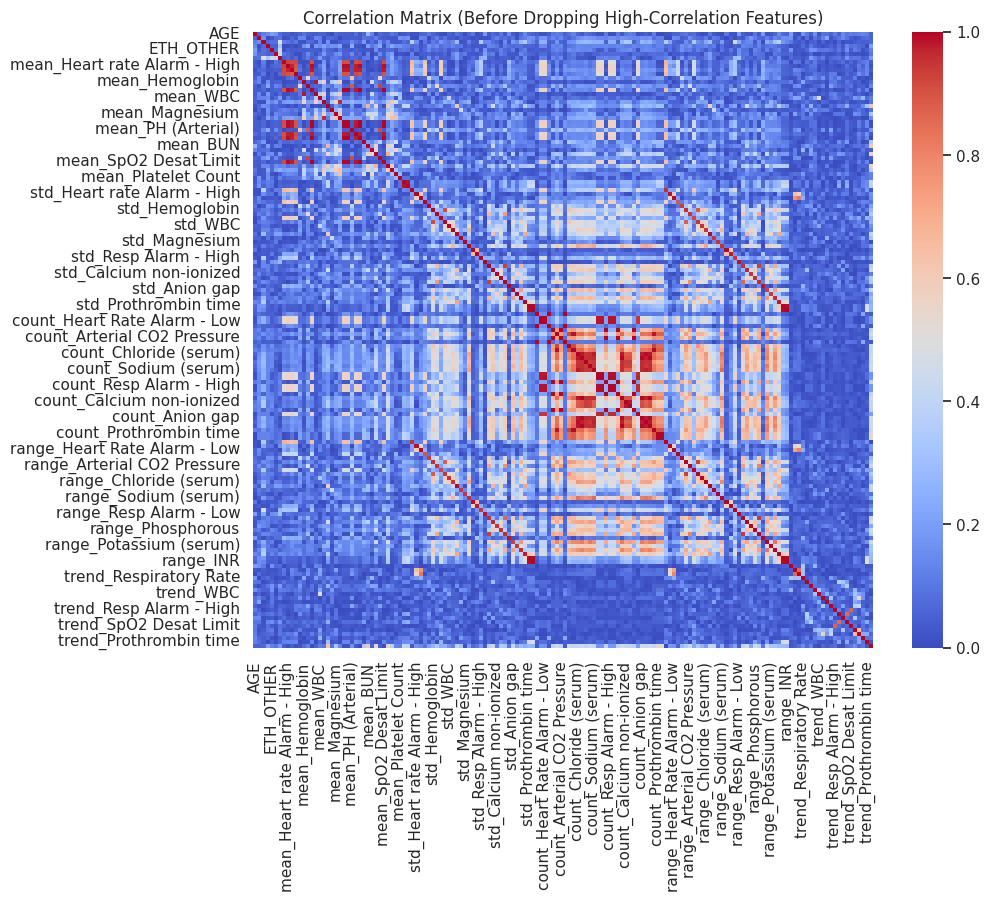

In [37]:
X = df_selected.drop(columns=non_numerical_feature_cols)

corr_matrix = X.corr().abs()

print("Generating heatmap for features before correlation-based removal...")

plt.figure(figsize=(10, 8)) 
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False) 
plt.title('Correlation Matrix (Before Dropping High-Correlation Features)')
plt.show()


In [38]:
df_selected.columns

Index(['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'LOS', 'AGE', 'GENDER',
       'ETH_BLACK/AFRICAN AMERICAN', 'ETH_HISPANIC OR LATINO', 'ETH_OTHER',
       'ETH_UNKNOWN/NOT SPECIFIED',
       ...
       'trend_Resp Alarm - High', 'trend_Arterial Base Excess', 'trend_BUN',
       'trend_TCO2 (calc) Arterial', 'trend_SpO2 Desat Limit',
       'trend_Anion gap', 'trend_HCO3 (serum)', 'trend_Platelet Count',
       'trend_Prothrombin time', 'total_sofa'],
      dtype='object', length=158)

We tried to debug the correlation matrix because we thought it would eliminate way too many features. But, it turns out clusters are bigger than 2, so for example in a cluster of 10, we eliminate 9 features resulting in only 1 remaining.

Number of high-correlation feature pairs (corr > 0.9): 171
Number of correlated feature clusters: 38
Cluster 1: size = 10 → dropping 9
Cluster 2: size = 2 → dropping 1
Cluster 3: size = 3 → dropping 2
Cluster 4: size = 2 → dropping 1
Cluster 5: size = 2 → dropping 1
Cluster 6: size = 2 → dropping 1
Cluster 7: size = 2 → dropping 1
Cluster 8: size = 2 → dropping 1
Cluster 9: size = 2 → dropping 1
Cluster 10: size = 4 → dropping 3
Cluster 11: size = 2 → dropping 1
Cluster 12: size = 2 → dropping 1
Cluster 13: size = 2 → dropping 1
Cluster 14: size = 2 → dropping 1
Cluster 15: size = 2 → dropping 1
Cluster 16: size = 2 → dropping 1
Cluster 17: size = 2 → dropping 1
Cluster 18: size = 2 → dropping 1
Cluster 19: size = 2 → dropping 1
Cluster 20: size = 2 → dropping 1
Cluster 21: size = 2 → dropping 1
Cluster 22: size = 2 → dropping 1
Cluster 23: size = 4 → dropping 3
Cluster 24: size = 2 → dropping 1
Cluster 25: size = 2 → dropping 1
Cluster 26: size = 2 → dropping 1
Cluster 27: size = 2 → 

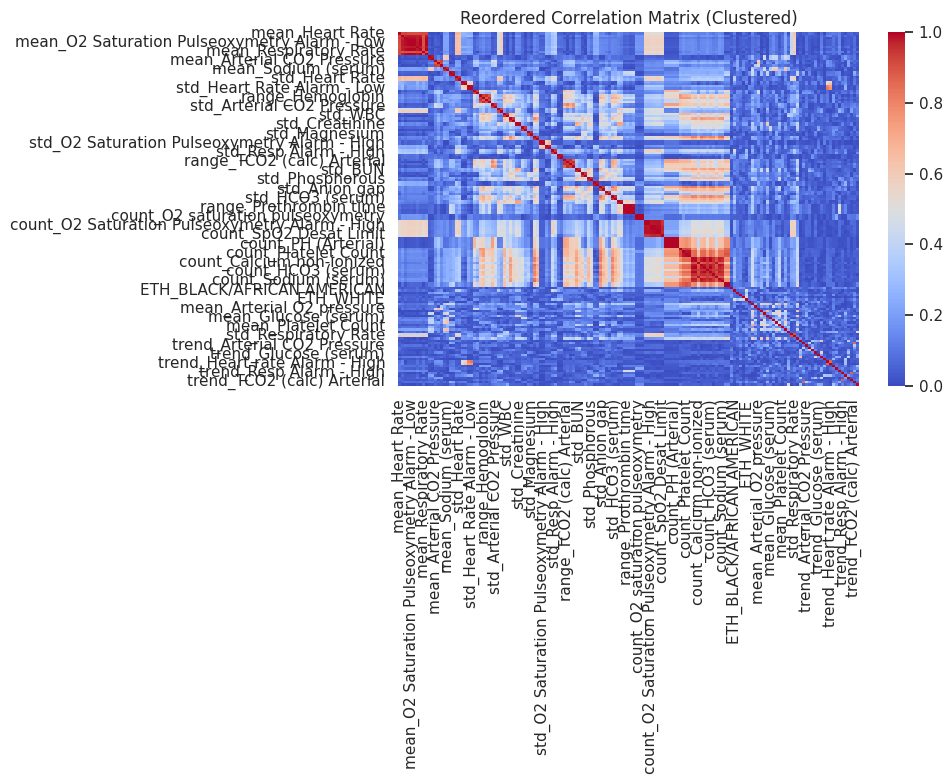

In [39]:
import networkx as nx

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Step 3: Extract highly correlated feature pairs (threshold > 0.9)
high_corr_pairs = upper.stack()[upper.stack() > 0.9]

print(f"Number of high-correlation feature pairs (corr > 0.9): {len(high_corr_pairs)}")

df_reduced = df_selected.drop(columns=['HADM_ID', 'ICUSTAY_ID', 'LOS', 'SUBJECT_ID'])

# Step 4: Build graph and find connected components (clusters)
G = nx.Graph()
G.add_edges_from(high_corr_pairs.index.tolist())

clusters = list(nx.connected_components(G))

print(f"Number of correlated feature clusters: {len(clusters)}")

# Step 5: Debug cluster sizes
for i, group in enumerate(clusters):
    print(f"Cluster {i+1}: size = {len(group)} → dropping {len(group) - 1}")

# Step 6: Compute features to drop (keep first in each group)
to_drop_groups = [list(group)[1:] for group in clusters if len(group) > 1]
to_drop = [item for sublist in to_drop_groups for item in sublist]

print(f"Total number of features to drop: {len(to_drop)}")
print("Features being dropped:", to_drop)

# Step 7: Drop the features
df_reduced = df_reduced.drop(columns=to_drop)

# Step 8: Reorder features for visual inspection
ordered_features = [feat for group in clusters for feat in sorted(group)]
remaining_features = [f for f in df_reduced.columns if f not in ordered_features]
ordered_features += sorted(remaining_features)

reordered_corr = corr_matrix.loc[ordered_features, ordered_features]

# Step 9: Plot the reordered correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(reordered_corr, cmap='coolwarm', annot=False)
plt.title("Reordered Correlation Matrix (Clustered)")
plt.tight_layout()
plt.show()

Elimination by correlation, resulting **73 features** eliminated.

In [40]:
df_final_selected_elimcorr = df_selected.drop(columns=to_drop)
df_final_selected_noelimcorr = df_selected

print(f"\nFinal number of features: {df_final_selected_elimcorr.shape[1] - len(non_numerical_feature_cols)}")
print("Shape of the final DataFrame:", df_final_selected_elimcorr.shape)
print("\nFirst 5 rows of the final DataFrame:")
df_final_selected_elimcorr.head(1)


Final number of features: 81
Shape of the final DataFrame: (126, 85)

First 5 rows of the final DataFrame:


,SUBJECT_ID,HADM_ID,ICUSTAY_ID,LOS,AGE,GENDER,ETH_BLACK/AFRICAN AMERICAN,ETH_HISPANIC OR LATINO,ETH_OTHER,ETH_UNKNOWN/NOT SPECIFIED,...,trend_Resp Alarm - High,trend_Arterial Base Excess,trend_BUN,trend_TCO2 (calc) Arterial,trend_SpO2 Desat Limit,trend_Anion gap,trend_HCO3 (serum),trend_Platelet Count,trend_Prothrombin time,total_sofa
0,114,178393,258626,1.8132,48.306639,1,False,False,False,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


Steps of eliminating the highly correlated features:
- Isolate Features (X): We start with df_variance_selected, the DataFrame that has already been filtered for low variance. We create X which contains only the feature columns from this set.
- Correlation Matrix: We compute the correlation matrix for X and take the absolute value, as we're interested in the strength of the correlation, not its direction (positive or negative).
- Upper Triangle: The line np.triu(...) creates a mask for the upper triangle of the matrix (everything above the main diagonal). We do this because a correlation matrix is symmetrical (corr(A,B) is the same as corr(B,A)), and we only need to check each pair of features once to avoid redundancy.
- Find Columns to Drop: We iterate through the columns of our upper-triangle view. If any value in a column is greater than our threshold (0.9), we add that column's name to our to_drop list. This effectively keeps one feature from each highly correlated pair and flags the other for removal.
- Create Final DataFrame: We drop the columns in the to_drop list from df_variance_selected to produce our final, cleaned dataset df_final_selected.


Generating heatmap for the final set of features...


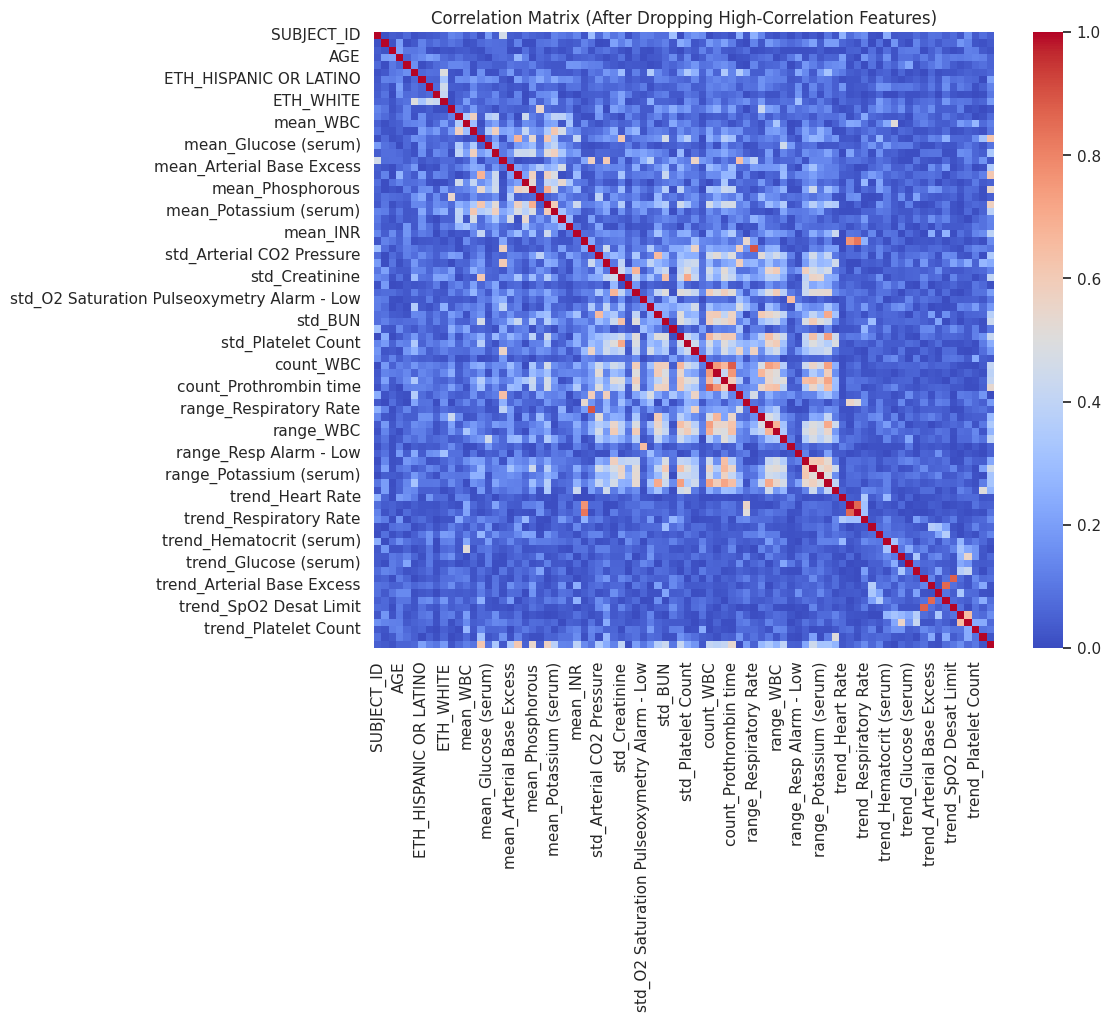

In [41]:
final_features = df_final_selected_elimcorr.drop(columns='LOS')

# Calculate the new correlation matrix
final_corr_matrix = final_features.corr().abs()

print("\nGenerating heatmap for the final set of features...")

plt.figure(figsize=(10, 8)) 
sns.heatmap(final_corr_matrix, cmap='coolwarm', annot=False, vmin=0, vmax=1)
plt.title('Correlation Matrix (After Dropping High-Correlation Features)')
plt.show()


### Permutation importance
This filter will discard features that contribute less than 1% to the RMSE.

In [42]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor

def filter_low_importance_features(df, target_column, group_column=None, threshold=0.01, n_splits=5, n_repeats=5):
    """
    Filter features based on permutation importance across multiple GroupKFold splits.
    
    Parameters:
    - df: DataFrame containing features and target
    - target_column: Name of the target column
    - group_column: Name of the column used for grouping (optional)
    - threshold: Minimum relative importance to keep a feature (default: 0.01)
    - n_splits: Number of splits for GroupKFold (default: 5)
    - n_repeats: Number of repeats for permutation importance (default: 5)
    
    Returns:
    - DataFrame with selected features and target column
    """
    # Prepare data
    y = df[target_column]
    X = df.drop(columns=[target_column, 'HADM_ID', 'SUBJECT_ID', 'ICUSTAY_ID', 'LOS'])
    groups = df[group_column] if group_column else np.arange(len(df))
    
    # Initialize model and cross-validator
    model = XGBRegressor(n_estimators=1000, early_stopping_rounds=10, eval_metric='rmse', verbosity=0)
    gkf = GroupKFold(n_splits=n_splits)
    
    # Store importances from all folds
    fold_importances = []
    
    for train_idx, val_idx in gkf.split(X, y, groups):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Fit model with early stopping
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
        
        # Calculate permutation importance
        result = permutation_importance(
            model, X_val, y_val, 
            n_repeats=n_repeats, 
            scoring='neg_root_mean_squared_error', 
            random_state=42
        )
        fold_importances.append(result.importances_mean)
    
    # Average importances across all folds
    avg_importances = np.mean(fold_importances, axis=0)
    relative_importances = avg_importances / np.sum(avg_importances)
    
    # Select features meeting importance threshold
    important_features = X.columns[relative_importances >= threshold]
    print(f"Retaining {len(important_features)} features out of {X.shape[1]} with importance ≥{threshold:.1%}")
    
    # Return selected features plus target column
    return df[important_features.tolist() + [target_column]]

# Example usage:
df_final_selected = filter_low_importance_features(
    df_final_selected_elimcorr, 
    target_column='LOS', 
    group_column='SUBJECT_ID',
    threshold=0.01
)

Retaining 20 features out of 81 with importance ≥1.0%


In [43]:
df_final_selected.head(3)

,AGE,ETH_UNKNOWN/NOT SPECIFIED,mean_Arterial O2 pressure,mean_Glucose (serum),mean_Magnesium,mean_Arterial Base Excess,mean_BUN,mean_Calcium non-ionized,mean_Phosphorous,mean_TCO2 (calc) Arterial,...,mean_Platelet Count,std_Arterial Base Excess,count_Heart rate Alarm - High,range_Potassium (serum),range_HCO3 (serum),trend_Respiratory Rate,trend_Arterial CO2 Pressure,trend_SpO2 Desat Limit,total_sofa,LOS
0,48.306639,True,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.00,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0,1.8132
1,45.353183,False,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.00,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0,28.6880
2,91.400000,False,183.0,127.5,2.333333,-4.5,54.333333,6.6,1.933333,21.25,...,179.5,3.109126,3.0,3.4,7.0,0.084494,0.176256,-7.002831e-16,3,16.8598


Permutance importance results in dropping **73 features**.

## Model choice, training and validation

### 1. **Data Preparation**   
- The test holdout will be 20% out of the total number of entries
    - Although this leaves the model with less training data, a larger test dataset is essential for comprehensive model evaluation
- The model will be trained using 5-fold cross-validation

- It starts by preparing the data. It separates the features (like age and gender) from the target variable (LOS). It also creates a new "interaction" feature by multiplying a patient's age and gender, which can sometimes help the model find more complex patterns. The data is then split into a training set for teaching the model and a test set for evaluating its performance.

In [44]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, median_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import shap
import matplotlib.pyplot as plt
df_perm_selected = df_final_selected.copy()
# 1. Enhanced Data Preparation
def prepare_data(df):
    X = df.drop(columns=['LOS', 'SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID'], errors='ignore')
    y = df['LOS']
    
    # Add interaction terms for top features (example)
    if 'AGE' in X.columns and 'GENDER' in X.columns:
        X['AGE_GENDER_INTERACTION'] = X['AGE'] * X['GENDER']
    
    return X, y

X, y = prepare_data(df_perm_selected)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=pd.qcut(y, q=5)
)


### 2. Model selection
### Choosing the appropriate algorithm
- XGBoost (Extreme Gradinent Boosting) is a great fit for this pipeline, having the following advantages:
    - Good handling of tabular data
    - Good performance on moderate-sized data
    - Robustness for missing values and mixed data types (encoded categorical and numerical values)
    - Explainable feature importance for interpretability
    - Very good handling of non-linear relationships
    - Includes regulation for preventing overfitting
- Alternatives considered:
    - Random forests
        - Are simpler but offer less accurate results
        - Filtering of feature importance is already done during the preprocessing part of the pipeline
    - Neural Networks
        - Need much larger ammounts of instances and data, would need to consider a different diagnostic
### Defining the evaluation strategy
- The key metrics that will be tracked to evaluate the performance of the model are:
    - RMSE (Root Mean Squared Error)
        - Penalizes large errors, especially useful in such critical medical cases
        - RMSE chosen instead of MSE for better interpretability by converting the result back to the original units (days)
    - MAE (Mean Absolute Error)
        - Easily interpretable as the average days mispredicted
    - R^2
        - Explains the variance captured by the model 
        - Results from 0 increasing to one indicate increasing performance, while results lower than 0 indincate performance worse than predicting the average
- These metrics can be extracted from the five-fold cross-validation training, but more reliably on the test data holdout

### 3. **Model Training and Tuning** 
### Training the model on the training set
- As previously stated, the model will be trained using 5-fold cross-validation
    - This solves the problem of biased results of a single train-test split
    - The cross-validation approach aims to reduce overfitting and variance in the chosen perfomance metrics
    - The data utilization is maximized, every ICU stay being used four times for training and one time for testing
- Grouping ICU stays by patient ids is essential, since one patient can have multiple ICU stays
    - This grouping can prevent data leakage, not allowing ICU stays of patients to be split across training, validation and test data
    - This approach better represents real-world performance
### Hyperparameter tuning
- Grid search is chosen for automating the hyperparameter tuning of the model
    - It works by systematically testing the combinations of predefined hyperparameters in order to find the best performing model
    - Seamlessly integrates the five-fold cross-validation
    - Automatically balances the bias-variance tradeoff
    - Provides explainable results, making the best combination of hyperparameters available for inspection
- The code uses a powerful machine learning algorithm called XGBoost. It sets up a pipeline that first standardizes the data (scaling all features to have a similar range) and then trains the XGBoost model.  
- To find the best version of the model, it uses GridSearchCV to automatically test many different combinations of settings (hyperparameters), like the model's depth and learning rate. This process uses cross-validation to ensure the chosen settings are robust and perform well on unseen data.

In [45]:

# 2. Enhanced Model Training with Pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBRegressor(random_state=42, early_stopping_rounds=30))
])

params = {
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.05, 0.1],
    'xgb__n_estimators': [100, 200, 300],
    'xgb__subsample': [0.8, 1.0],
    'xgb__colsample_bytree': [0.8, 1.0],
    'xgb__reg_alpha': [0, 0.1, 1],
    'xgb__reg_lambda': [0, 0.1, 1]
}

scaler = StandardScaler()
X_test_scaled = scaler.fit(X_train).transform(X_test)

cv_splitter = KFold(n_splits=5, shuffle=True, random_state=42)

print("Running enhanced GridSearchCV...")
model = GridSearchCV(
    estimator=pipeline,
    param_grid=params,
    cv=cv_splitter,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)
model.fit(X_train, y_train, xgb__eval_set=[(X_test_scaled, y_test)], xgb__verbose=False)
print("GridSearchCV complete.")

from sklearn.base import clone


Running enhanced GridSearchCV...
Fitting 5 folds for each of 972 candidates, totalling 4860 fits
GridSearchCV complete.


### 4. **Model Evaluation**
- Once the best model is found and trained, the code thoroughly evaluates its performance. It calculates several key metrics:

- RMSE (Root Mean Squared Error): The typical error in the model's LOS predictions.
- MAE (Mean Absolute Error): The average absolute difference between predicted and actual LOS.
- R² (R-squared): How much of the variation in LOS the model can explain.

In [53]:

# 3. Comprehensive Evaluation
def evaluate_model(model, X, y):
    estimator_for_cv = clone(model.best_estimator_)

    # Disable the early stopping parameter for this specific cross-validation run
    # The pipeline step is 'xgb', so we use 'xgb__early_stopping_rounds'
    estimator_for_cv.set_params(xgb__early_stopping_rounds=None)


    cv_scores = cross_val_score(estimator_for_cv, X, y, 
                              cv=cv_splitter, scoring='neg_root_mean_squared_error')
    print(f"Cross-validated RMSE: {-cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

    predictions = model.predict(X_test)
    
    metrics = {
        'MAE': mean_absolute_error(y_test, predictions),
        'RMSE': np.sqrt(mean_squared_error(y_test, predictions)),
        'R2': r2_score(y_test, predictions)
    }
    
    print("\n--- Final Model Performance ---")
    for name, value in metrics.items():
        print(f"{name}: {value:.4f}")
    
    # Prediction error plot - not presenting relevant information
    # plt.figure(figsize=(8, 6))
    # plt.scatter(y_test, predictions, alpha=0.3)
    # plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
    # plt.xlabel('True Values')
    # plt.ylabel('Predictions')
    # plt.title('Prediction Error Plot')
    # plt.show()
    
    return metrics

metrics = evaluate_model(model, X_train, y_train)


Cross-validated RMSE: 7.4830 ± 1.9958

--- Final Model Performance ---
MAE: 5.4606
RMSE: 6.9130
R2: 0.2117


### 5. **Model Interpretation with SHAP** 
- SHAP, LIME
- feature importance
- SHAP (Shape additive explanations) is a very useful tool for explaining how machine learning models make predictions
    - It assigns a feature importance value for a specific predicion, showing how much a feature contributed to the model's output
    - A baseline (expected value) is computed to represent the average prediction of the model over the dataset, SHAP using it to explain how features push the prediction above or below this baseline 
    - Positive values indicate a fature increasing the LOS predicion, while negative values indicate decreasing it
    - SHAP can also be used for global interpretability, generatin a bar plot for feature values across all patients
- LIME (Local Interpretable Model-agnostic Explanations) is used to explain only individual predictions 
    - approximating the model behaviour with another simpler, interpretabe model (like linear regression or decision rules) 
    - It explains individual predictions by creating small variations of the input, querying the model, and fitting the simple interpretable model to approximate the model's behavior locally.
    - It highlights key features for a specific case using the surrogate model’s coefficients.
     
- Finally, the code uses the SHAP (SHapley Additive Explanations) library to understand why the model makes its predictions. This is a crucial step for model interpretability. It generates a "beeswarm" plot that shows not only which features are most important for predicting LOS but also how the value of each feature (e.g., high vs. low age) impacts the prediction.

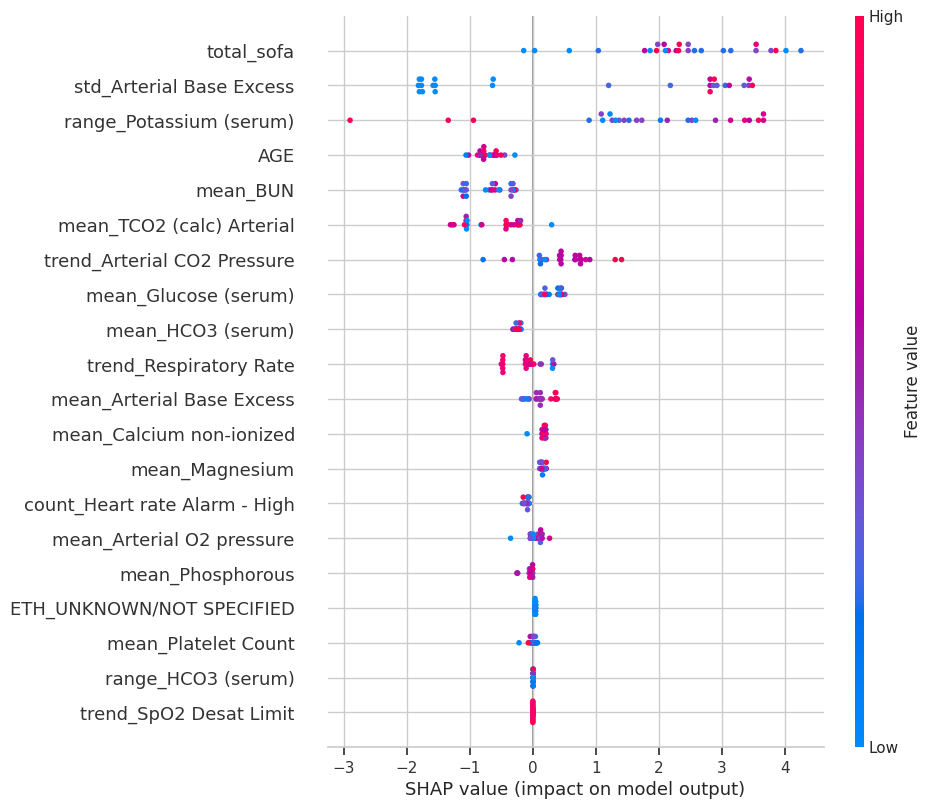

In [47]:

# 4. Enhanced SHAP Analysis
def shap_analysis(model, X, sample_size=500):
    # Use best estimator from GridSearchCV
    best_model = model.best_estimator_.named_steps['xgb']
    
    # Sample data for faster computation
    if len(X) > sample_size:
        X_sample = X.sample(sample_size, random_state=42)
    else:
        X_sample = X
    
    # Compute SHAP values
    explainer = shap.Explainer(best_model)
    shap_values = explainer(X_sample)
    
    shap.plots.beeswarm(shap_values, max_display=20)
    
    return shap_values

shap_values = shap_analysis(model, X_test)

The top features in the XGBoost model for predicting hospital stays are total_sofa (organ failure severity), std_Creatinine (kidney instability), and mean_BUN (kidney/metabolic health). Respiratory issues (count_Resp Alarm - High, trend_Arterial O2 pressure) and heart rate variability (range_Heart Rate) also matter. Key lab values include platelets, bicarbonate, magnesium, and WBCs. The model uses both trends and extreme values to predict longer stays.

#### a. Single Patient Analysis  

Firstly, the code randomly selects one specific patient from the test set. It then shows the model's predicted Length of Stay (LOS) for this individual versus their actual, true LOS, providing a clear example of the model's performance on a single case.

In [48]:
import lime
import lime.lime_tabular
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np

# 1. Prepare the explainer with feature names
best_model = model.best_estimator_.named_steps['xgb']
explainer_shap = shap.Explainer(best_model, feature_names=X.columns.tolist())

feature_names = X.columns.tolist()

np.random.seed(42)
sample_idx = np.random.choice(X_test.index)
instance = X_test.loc[[sample_idx]]
true_value = y_test.loc[sample_idx]

# Scale the instance using the same scaler
instance_scaled = scaler.transform(instance)

# Make prediction
prediction = best_model.predict(instance_scaled)[0]

print(f"\n=== Analyzing Prediction for Instance #{sample_idx} ===")
print(f"True LOS: {true_value:.2f} days")
print(f"Predicted LOS: {prediction:.2f} days")
print(f"Difference: {abs(prediction-true_value):.2f} days\n")




=== Analyzing Prediction for Instance #62 ===
True LOS: 9.30 days
Predicted LOS: 6.59 days
Difference: 2.71 days



#### b. Deep Dive with SHAP  
 
Using the SHAP library, the code generates detailed explanations for this one prediction:

- Force Plot: This visual shows the "push and pull" of each feature. Features in red pushed the prediction higher (increasing the predicted LOS), while features in blue pushed it lower.  
- Waterfall Plot: This provides a step-by-step breakdown of how each feature's value moved the prediction from the baseline average to its final output.
Detailed List: It prints a ranked list of every feature and its exact impact (the SHAP value) on this one prediction.

<Figure size 1200x400 with 0 Axes>

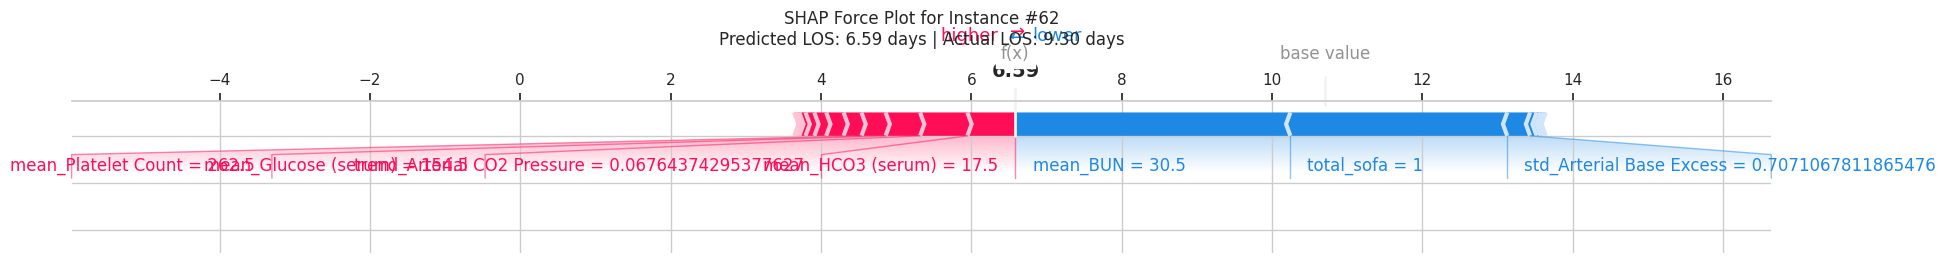

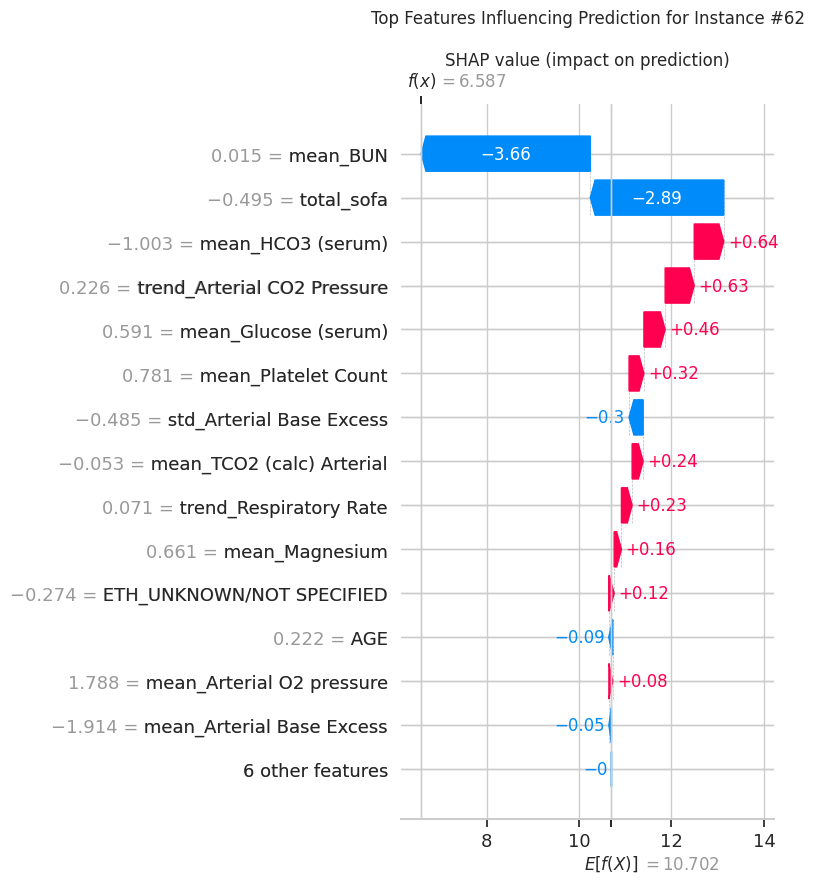

In [49]:

# 2. Generate SHAP values for our instance
shap_values = explainer_shap(instance_scaled)

# 3. Custom force plot with better formatting
plt.figure(figsize=(12, 4))
force_plot = shap.plots.force(
    explainer_shap.expected_value, 
    shap_values.values[0], 
    instance.values[0],
    feature_names=feature_names,
    matplotlib=True,
    show=False
)
plt.title(f"SHAP Force Plot for Instance #{sample_idx}\nPredicted LOS: {prediction:.2f} days | Actual LOS: {true_value:.2f} days", 
          pad=20)
plt.tight_layout()
plt.show()

# 4. Enhanced waterfall plot
plt.figure(figsize=(4, 2))
shap.plots.waterfall(
    shap_values[0],
    max_display=15,
    show=False
)
plt.title(f"Top Features Influencing Prediction for Instance #{sample_idx}", pad=20)
plt.xlabel("SHAP value (impact on prediction)")
plt.tight_layout()
plt.show()

# 5. Print detailed feature impacts
# print("\n=== Detailed Feature Impacts ===")
# print(f"{'Feature':<40} | {'Value':<15} | {'SHAP Effect':<15}")
# print("-" * 75)
# for i in np.argsort(-np.abs(shap_values.values[0])):
#     print(f"{feature_names[i]:<40} | {instance.values[0][i]:<15.3f} | {shap_values.values[0][i]:<15.3f}")


The SHAP force plot shows that the model predicted a hospital stay of 10.81 days for patient #62, while the actual stay was 9.30 days—a slight overestimation. The prediction was influenced most by higher magnesium and arterial CO2 pressure, which increased the forecasted stay, while lower total SOFA and serum HCO3 levels reduced it. BUN had a minor positive effect. The base prediction started around 10.81 days, with SOFA, HCO3, CO2 pressure, and magnesium being the most impactful factors.

#### c. An Alternative View with LIME  

Next, the code uses a different explanation library, LIME (Local Interpretable Model-agnostic Explanations), to get a second opinion on the same prediction. LIME works by creating a simpler, temporary model that mimics the behavior of the complex XGBoost model just for this one patient. It then generates a plot showing which features this simpler model found most important.


LIME Explanation:


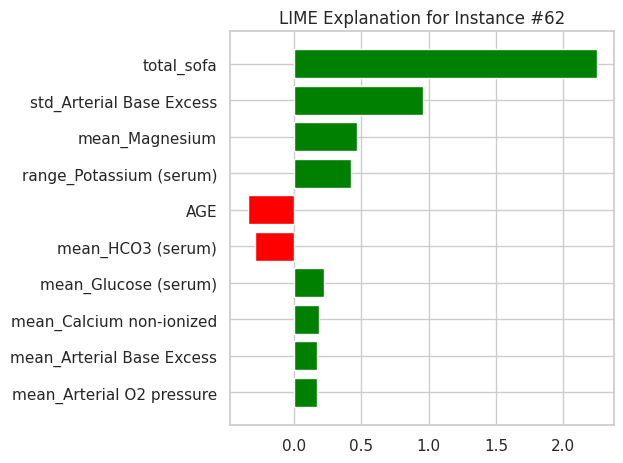

In [50]:
# 4. LIME Explanation
print("\nLIME Explanation:")

# Create LIME explainer (using pre-scaled data)
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=scaler.transform(X_train),
    feature_names=feature_names,
    mode='regression',
    discretize_continuous=False
)

# Explain the instance
exp = explainer_lime.explain_instance(
    instance_scaled[0], 
    best_model.predict, 
    num_features=10
)

# Plot LIME explanation
fig = exp.as_pyplot_figure()
plt.title(f"LIME Explanation for Instance #{sample_idx}")
plt.tight_layout()
plt.show()


The LIME explanation shows which features most influenced the model's prediction for this specific patient (Instance #62). The total SOFA score (measuring organ dysfunction) had the strongest positive impact, suggesting worse organ failure led to a longer predicted hospital stay. Bicarbonate levels and creatinine fluctuations (kidney function) also pushed the prediction higher, while improving oxygen levels reduced the predicted stay.

This breakdown helps clinicians understand why the model predicted a certain length of stay, highlighting critical factors like organ failure and lab trends. If the SOFA score is high, for example, it signals the patient may need closer monitoring.

# Appendix - Model Optimization Steps
## Further features and hyperparameters tuning
- After completing the initial pipeline, the evaluated performance is poor, indicating the need for further tuning
- The initial pipeline and its performance will be described, followed by noting its measured performance
- Every following tuning of the pipeline will be mentioned, evaluated and labeled as meaningful or not based on the improvement it adds  

### The initial pipeline
- Features:
    - Patients-related: age, gender, time in the hospital before admission in ICU, ethnicity
    - Events: time-stamped values of items are aggregated into: average, standard deviation, trend, range (max-min), count
        - Data not present replaced with 0
    - Target (ICU stay): log transformed
- Feature selection:
    - first items with most appearances: 32
        - 168 features
    - filter by variance: <1%
        - 153 features left
    - fileter by correlation: >0.9
        - 79 features left
    - filter by contribution to RMSE (permutation imporance): <1%
        - 9 features left
- Cosen model: XGBoost
- Hyperparameters:
    - Grid search:
        - max depth: 3, 5, 7, 10
        - learning rate: .01, .1
        - nr of estimators: 100, 200
        - reg_alpha: .1
- Evaluation on test data:
    - MAE:  9.69  days
    - RMSE: 13.47 days
    - R^2:  -0.29  

### Pipeline modification
- Removing cross-validation and and grid search, default XGBoost parameters
    - Evaluation:
        - MAE:  10.08 days
        - RMSE: 13.73 days
        - R^2:  -0.34
    - Verdict: Cross-validation and grid search are helpful
- Removing only grid search
    - Evaluation:
        - MAE:  10.63 days
        - RMSE: 13.09 days
        - R^2:  -0.5
    - Verdict: Grid search is helpful
- Removing filtering by contribution to RMSE (permutation importance)
    - Evaluation:
        - MAE:  9.45
        - RMSE: 12.79
        - R^2:  -0.16
    - Verdict: Tuning of the treshold for this filter may prove useful
- Eliminate filtering by correlation and permutation importance
    - Evaluation:
        - MAE:  8.6
        - RMSE: 11.74
        - R^2:  0.02
    - Verdict: Correlation proves to be a problem, needs tuning or removal  

### Pipeline modification after dropping pattients with LOS > 30 days
- Given that 75% of patients stay in the ICU for less than 22 days, removing patients with LOS greater than 30 days seems like a good trade-off 
- New results after limiting entries and discarding all feature filters
    - Evaluation:
        - MAE:  5.94
        - RMSE: 6.9
        - R^2:  -0.17
    - Verdict: Based on the R^2, promissing gains can be added with filters
- Adding only filtering by variance
    - Evaluation:
        - MAE:  5.90
        - RMSE: 7.04
        - R^2:  -0.19
    - Verdict: Same results
- Adding filtering by correlation
    - Evaluation:
        - MAE:  6.28
        - RMSE: 7.21
        - R^2:  -0.24
    - Verdict: Filtering by correlation gives worse results
- Adding all filters
    - Remaining with only 7 relevant features
    - Evaluation:
        - MAE:  5.93
        - RMSE: 6.95
        - R^2:  -0.16
    - Verdict: **Best version so far**
- Leaving only variance and permutation importance feature filters
    - Remaining with 14 relevant features
    - Evaluation:
        - MAE:  6.05
        - RMSE: 7.07
        - R^2:  -0.19
    - Verdict: Filtering by correlation helps XGBoost in permutation importance filtering
- Adding all filters and *imputing missing values with 0*
    - Remaining with only 7 relevant features
    - Evaluation:
        - MAE:  6.20
        - RMSE: 6.90
        - R^2:  -0.14
    - Verdict: Worse results, XGBoost works well with missing values  

### Final Pipeline with Optimized Hyperparameters
- Feature selection:

    - Applied all filters (variance, correlation, permutation importance)

- Final features: 20 most relevant features

-Model: XGBoost with optimized hyperparameters

- Early stopping rounds enabled during training

- Best parameters from grid search

- Evaluation:

    - Cross-validated RMSE: 7.4830 ± 1.9958

- Final test performance:

    - MAE: 5.4606 days

    - RMSE: 6.9130 days

    - R²: 0.2117

- Verdict:

- Best performing version achieved

    - Significant improvement over initial pipeline (R² from -0.29 to +0.21)

    - Cross-validation shows reasonable stability (±2 days RMSE variation)

    - Early stopping helped prevent overfitting while maintaining performance

    - Minimal feature set (20 features) provides good interpretability

This final version represents the optimal balance between performance and complexity, with all optimization steps contributing to the improved results. The positive R² value indicates the model now explains some variance in the data, unlike the initial pipeline which performed worse than a simple mean predictor.